# R vs Python

In [0]:
%load_ext rpy2.ipython

In [21]:
%%R
system.time({
    n <- 5000
    A <- matrix(runif(n^2), ncol = n)
    invA <- solve(A)
})
# elapsed is the wall clock time taken to execute the functio

# “User CPU time” gives the CPU time spent by the current process 
# (i.e., the current R session) and “system CPU time” gives the CPU time 
# spent by the kernel (the operating system) on behalf of the current process. 
# The operating system is used for things like opening files, doing input or output, 
# starting other processes, and looking at the system clock: operations that involve
# resources that many processes must share. Different operating systems will have 
# different things done by the operating system.

   user  system elapsed 
 23.492   0.368  12.745 


In [0]:
import numpy as np
import time


In [23]:
%%time
n = 5000
A = np.random.rand(n,n)
invA = np.linalg.inv(A)

CPU times: user 20.5 s, sys: 209 ms, total: 20.7 s
Wall time: 10.9 s


# Simulación

En R

In [0]:
%%R
b <- 1
sigma2_b <- 0.01 
sigma2_f <- 0.000158
sigma_e <- 0.0045
n <- 80
k <- 4
i <- c(50:200)


In [32]:
%%R
system.time({
    lambda_1 <- sapply(i, function(i) (sigma2_f*i)*((b^2)*k+sigma2_b) + sigma_e)
    lambda_2 <- sapply(i, function(i) sigma2_f*i*sigma2_b + sigma_e)
    lambda_3 <- sapply(i, function(i) sigma_e)
})

   user  system elapsed 
  0.007   0.000   0.008 


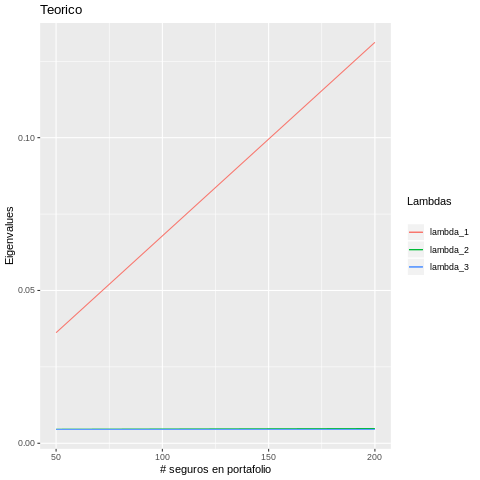

In [38]:
%%R
library(magrittr)
library(tidyverse)
library(ggplot2)


teorico <- data.frame(P = seq(50,200,1), lambda1 = lambda_1,
                lambda2 = lambda_2,lambda3 = lambda_3)


teorico %>%  ggplot() + geom_line(aes(x= P, y = lambda1, col="lambda_1")) +
  geom_line(aes(x= P, y = lambda2, col="lambda_2")) +
  geom_line(aes(x= P, y = lambda3, col="lambda_3")) +
  labs(title = "Teorico", x = "# seguros en portafolio" , y = "Eigenvalues", color = "Lambdas\n") 

In [39]:
%%R
##################
# Parámetros
##################
b = 1.0 
k = 4.0
sigma2_b = 0.01
sigma2_f = 0.000158
sigma2_e = 0.0045
n = 80
p = range(50,201)

system.time({
Matriz <- matrix(0L, length(seq(50,200,1)), 5)
LOWER <- matrix(0L, length(seq(50,200,1)), 5)
UPPER <- matrix(0L, length(seq(50,200,1)), 5)
for(i in seq(50,200,1)){
  R_ <- matrix(0L, 100, 5)
  for(j in 1:100){
    F_ <- matrix( rnorm(n*k,mean=0,sd= sigma2_f %>% sqrt), n, k) 
    L <- matrix( rnorm(i*k,mean=b,sd= sigma2_b %>% sqrt), i, k)
    E <- matrix( rnorm(i*n,mean=0,sd= sigma_e %>% sqrt), i, n)
    R <- L%*%t(F_) + E
    Sigma <- (R%*%t(R))/n
    Valores <- Sigma %>% eigen()
    valores_propios <- sort(Valores$values, decreasing = TRUE)[1:5]
    R_[j,] <- valores_propios
    Low <-  quantile(R_[,1], .25)
    Upp <-  quantile(R_[,1], .75)
  }
  vp <- colMeans(R_)
  Matriz[i-49,] <- vp
  LOWER[i-49,] <- Low
  UPPER[i-49,] <- Upp
}
})

   user  system elapsed 
146.546  93.599 120.605 


En Python

In [0]:
##################
## Brown model
##################
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
##################
# Parámetros
##################
b = 1.0 
k = 4.0
sigma2_b = 0.01
sigma2_f = 0.000158
sigma2_e = 0.0045
n = 80
p = range(50,201)

In [31]:
%%time
##################
# Modelo teórico
##################
k = 4.
lambda_1 = [sigma2_f*i*((1.*b**2)*1.*k+sigma2_b)+sigma2_e for i in p]
lambda_2 = [sigma2_f*i*sigma2_b+sigma2_e for i in p]
lambda_3 = [sigma2_e for i in p]

CPU times: user 106 µs, sys: 35 µs, total: 141 µs
Wall time: 144 µs


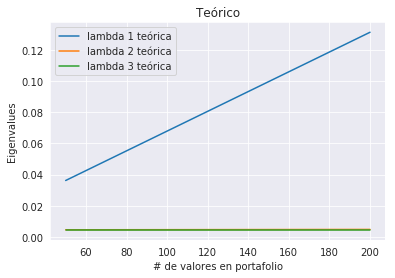

In [26]:
plt.plot(list(p), lambda_1, label='lambda 1 teórica')
plt.plot(list(p), lambda_2, label='lambda 2 teórica')
plt.plot(list(p), lambda_3, label='lambda 3 teórica')
plt.title("Teórico")
plt.xlabel("# de valores en portafolio")
plt.ylabel("Eigenvalues")
plt.legend()

In [0]:
####################
# Modelo Empírico 2
####################
Matriz = np.zeros((151,5), dtype=float)
LOWER = np.zeros((151,5), dtype=float)
UPPER = np.zeros((151,5), dtype=float)


In [0]:
##################
# Parámetros
##################
b = 1.0 
k = 4.0
sigma2_b = 0.01
sigma2_f = 0.000158
sigma2_e = 0.0045
n = 80
p = range(50,201)

In [72]:
%%time
for i in p:      
    R_ = np.zeros((100, 5))
    for j in range(100):
        F = np.random.normal(0, np.sqrt(sigma2_f), (n, 4))
        L = np.random.normal(b,  np.sqrt(sigma2_b), (i, 4))
        epsilon =  np.random.normal(0,  np.sqrt(sigma2_e), (i, n))
        R = np.dot(L,F.T) + epsilon
        Sigma = np.dot(R,R.T) / (1.*n)
        v, w = np.linalg.eigh(Sigma)
        temp = np.sort(v)
        temp_2 = temp[::-1]
        R_[j,:] =  temp_2[0:5]
        Low =  np.quantile(R_[:,0], .25)
        Upp =  np.quantile(R_[:,0], .75)
    vp = R_.mean(axis=0)
    Matriz[i-50,:] = vp
    LOWER[i-50,:] = Low
    UPPER[i-50,:] = Upp

CPU times: user 1min 36s, sys: 53.5 s, total: 2min 29s
Wall time: 1min 15s


Text(0, 0.5, 'Eigenvalues')

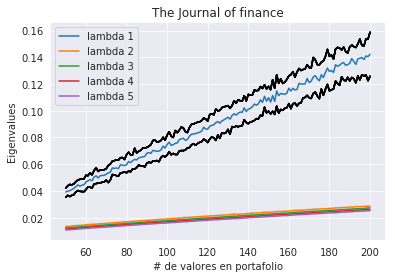

In [73]:
plt.plot(np.asarray(list(p)), Matriz[:,0], label='lambda 1')
plt.plot(np.asarray(list(p)), Matriz[:,1], label='lambda 2')
plt.plot(np.asarray(list(p)), Matriz[:,2], label='lambda 3')
plt.plot(np.asarray(list(p)), Matriz[:,3], label='lambda 4')
plt.plot(np.asarray(list(p)), Matriz[:,4], label='lambda 5')
plt.plot(np.asarray(list(p)), LOWER, c ="black")
plt.plot(np.asarray(list(p)), UPPER, c ="black")
plt.legend()
plt.title("The Journal of finance")
plt.xlabel("# de valores en portafolio")
plt.ylabel("Eigenvalues")